Para abrir o notebook no Google Colab, altere o domínio `github.com` para `githubtocolab.com`

# PSI3471 - Aula de Exercícios 06

# MLP com PyTorch

Considere o a seguinte solução em PyTorch, para o problema das meias-luas:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
# Fixando seeds para poder reproduzir os resultados
np.random.seed(111)
torch.manual_seed(111)
torch.cuda.manual_seed(111)

In [3]:
# Função para garar dados de treinamento
def meias_luas(NA, NB, r1, r2, r3):
    """
    dados = meias_luas(NA,NB,r1,r2,r3)
    NA: número de pontos da região A
    NB: número de pontos da região B
    r1, r2 e r3: dados das meias-luas
    """

    # total de dados de treinamento
    Nt = NA + NB

    # dados das meia luas
    rmin = r1 - r3 / 2
    rmax = r1 + r3 / 2

    # Pontos da Região A
    a = np.pi * np.random.rand(NA, 1)
    rxy = np.random.uniform(rmin, rmax, (NA, 1))
    x1A = rxy * np.cos(a)
    x2A = rxy * np.sin(a)
    dA = np.ones((NA, 1))
    pontosA = np.hstack((x1A, x2A, dA))

    # Pontos da Região B
    a = np.pi * np.random.rand(NB, 1)
    rxy = np.random.uniform(rmin, rmax, (NB, 1))
    x1B = rxy * np.cos(a) + r1
    x2B = -rxy * np.sin(a) - r2
    dB = -np.ones((NB, 1))    
    pontosB = np.hstack((x1B, x2B, dB))

    # Concatenando e embaralhando os dados
    dados = np.vstack((pontosA, pontosB))
    np.random.shuffle(dados)

    # Figura para mostrar os dados de treino
    fig, ax1 = plt.subplots()
    ax1.plot(x1A, x2A, ".b")
    ax1.plot(x1B, x2B, ".r")
    plt.xlabel("x_1")
    plt.ylabel("x_2")
    plt.grid(axis="x", color="0.5")
    plt.grid(axis="y", color="0.5")

    return dados

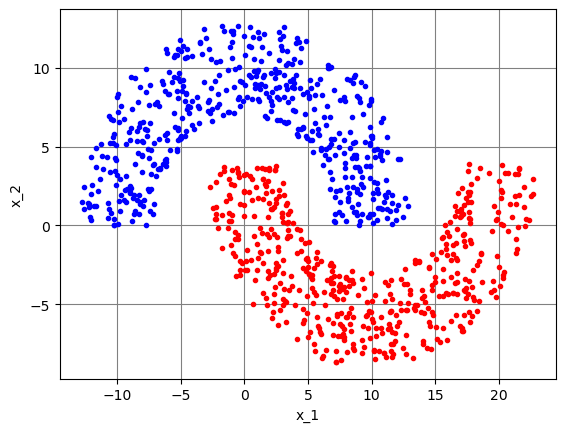

In [4]:
# Gerando dados de treinamento
# Note o uso do sufixo `_np` para facilitar a identificação
# de arrays do NumPy e não confundi-los com tensores do PyTorch

# número de pontos de treinamento da Região A
NA = 500

# número de pontos de treinamento da Região B
NB = 500

# número total de dados de treinamento
Nt = NA + NB

r1 = 10
r3 = 6
r2 = -4

dados_treino_np = meias_luas(NA, NB, r1, r2, r3)

In [5]:
# Ajuste de hiperparâmetros

# passo de adaptação da rede MLP
eta = 0.5

# Tamanho do mini-batch
Nb = 50

# Número de épocas
Ne = 1000

In [6]:
dados_treino = torch.tensor(dados_treino_np, dtype=torch.float32)
train_set = [
    (dados_treino[:, [0, 1]], dados_treino[:, [2]])
    for i in range(dados_treino.shape[0])
]

train_loader = torch.utils.data.DataLoader(train_set, batch_size=Nb, shuffle=True)

In [7]:
class Model(nn.Module):

    # Geralmente, os blocos da rede são definidos no método __init__()
    def __init__(self):
        # Necessário chamar __init__() da classe mãe
        super().__init__()
        
        # Uma das formas de se definir um modelo é a sequencial
        self.model = nn.Sequential(
            # Entrada com 2 elementos, conectada a 3 neurônios
            nn.Linear(2, 3),
            # Função de ativação Tanh
            nn.Tanh(),
            
            # Saídas de 3 neurônios conectadas a 5 neurônios
            nn.Linear(3, 5),
            nn.Tanh(),
            
            nn.Linear(5, 5),
            nn.Tanh(),
            
            nn.Linear(5, 2),
            nn.Tanh(),
            
            nn.Linear(2, 1),
            nn.Tanh(),            
        )

    # O método forward() define como é feito o cálculo progressivo
    # para obter a saída da rede, a partir da entrada x.
    # Nesse caso, como foi definido um modelo sequencial em
    # self.model, basta chamar self.model(x)
    def forward(self, x):
        output = self.model(x)
        return output

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    

model = Model().to(device=device)

loss_function = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=eta)

Época: 0 Loss: 0.41760480403900146
Época: 100 Loss: 8.947559399530292e-05
Época: 200 Loss: 2.1382862541940995e-05
Época: 300 Loss: 1.2412538126227446e-05
Época: 400 Loss: 8.778717528912239e-06
Época: 500 Loss: 6.800942173867952e-06
Época: 600 Loss: 5.554730705625843e-06
Época: 700 Loss: 4.696663381764665e-06
Época: 800 Loss: 4.069476290169405e-06
Época: 900 Loss: 3.590661208363599e-06


Text(0, 0.5, 'Loss')

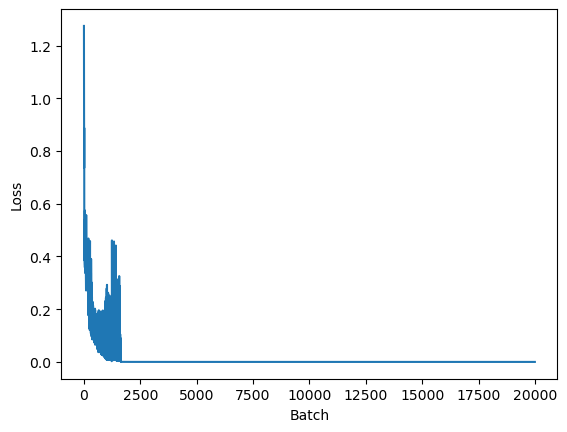

In [9]:
# Lista usada para guardar o valor da função custo ao longo das iterações
losses = []

# Loop das épocas
for epoch in range(Ne):
    # Loop dos mini batches - note que é usado o DataLoader para obter
    # os sinais de entrada e desejado, X e d
    for n, (X, d) in enumerate(train_loader):

        # Envia os dados para a GPU, caso ela exista
        X = X.to(device=device)
        d = d.to(device=device)
        
        # Coloca o modelo em modo treinamento. Isso não é necessário nesse
        # caso, pois não estamos fazendo validação. Mas é interessante manter
        # a linha para lembrar desse detalhe
        model.train()

        # Zera informações de gradientes: por padrão o PyTorch acumula os 
        # gradientes a cada chamada de loss.backward(). Na maioria dos casos,
        # estamos interessados apenas no último valor dos gradientes
        model.zero_grad()
        
        # Calcula a saída
        y = model(X)

        # Calcula o valor da função custo
        loss = loss_function(y, d)
        
        # Calcula os gradientes
        loss.backward()
        
        # Atualiza os pesos do modelo, de acordo com as regras
        # do otimizador escolhido
        optimizer.step()
        
        # Armazena o valor da função custo
        losses.append(loss.item())
        
        # Mostra o valor da função custo a cada 100 épocas        
        if epoch % 100 == 0 and n == dados_treino.shape[0]//Nb - 1:
            print(f"Época: {epoch} Loss: {loss}")

plt.figure()
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")

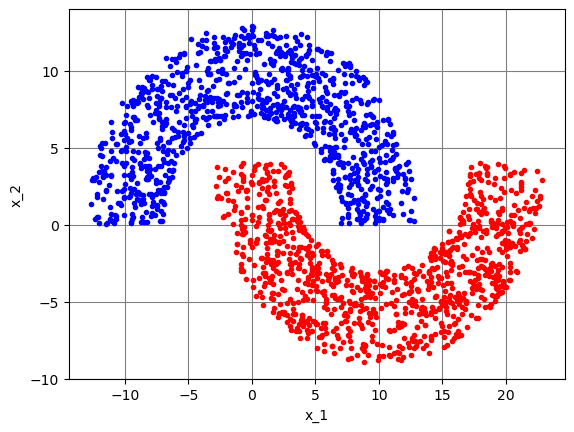

In [10]:
# Dados de teste
NAt = 1000
NBt = 1000
Nteste = NAt + NBt

dados_teste = meias_luas(NAt, NBt, r1, r2, r3)

In [11]:
xteste = torch.tensor(dados_teste[:,[0,1]], dtype=torch.float32).to(device=device)
dteste = torch.tensor(dados_teste[:,[2]], dtype=torch.float32).to(device=device)

In [12]:
yteste = model(xteste)
yteste_np = yteste.cpu().detach().numpy()

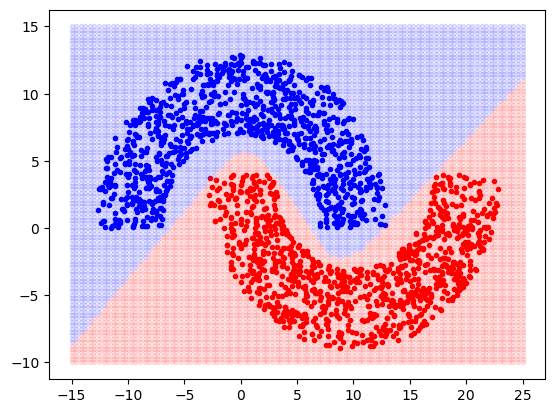

In [13]:
# Gera a curva de separação das duas regiões
# Dados da curva de separação
Nsep = 100
x1S = np.linspace(-15, 25, Nsep).reshape(-1, 1)
x2S = np.linspace(-10, 15, Nsep).reshape(-1, 1)

# Gera pontos da grade
xx1S, xx2S = np.meshgrid(x1S, x2S)
xx1S = xx1S.reshape(-1, 1)
xx2S = xx2S.reshape(-1, 1)

# Gera array x
Ngrid = len(xx1S)
xgrid_np = np.hstack((xx1S, xx2S))

# Calcula saída para cada ponto da grade
xgrid = torch.tensor(xgrid_np, dtype=torch.float32).to(device=device)
ygrid = model(xgrid)
ygrid_dec = torch.sign(ygrid)

ygrid_np = ygrid.cpu().detach().numpy()
ygrid_dec_np = ygrid_dec.cpu().detach().numpy()

xteste_np = xteste.cpu().detach().numpy()
dteste_np = dteste.cpu().detach().numpy()

# Plota os pontos principais
fig, ax2 = plt.subplots()
for i in range(Nteste):
    if dteste_np[i] == 1:
        ax2.plot(xteste_np[i, 0], xteste_np[i, 1], ".b")
    else:
        ax2.plot(xteste_np[i, 0], xteste_np[i, 1], ".r")

# Plota pontos da grade com saída 0 (usa transparência alpha)        
l0 = np.where(ygrid_dec_np == -1)[0]
ax2.plot(xgrid_np[l0, 0], xgrid_np[l0, 1], "r.", alpha=0.1)

# Plota pontos da grade com saída 1 (usa transparência alpha)
l1 = np.where(ygrid_dec_np == 1)[0]
ax2.plot(xgrid_np[l1, 0], xgrid_np[l1, 1], "b.", alpha=0.1)

In [14]:
yteste_np_dec = np.sign(yteste_np)

Taxa_de_erro = np.sum(np.absolute(dteste_np - yteste_np_dec)) * 100 / (2 * Nteste)

print(f"Taxa de erro: {Taxa_de_erro}")

Taxa de erro: 0.05


<div class="alert alert-block alert-success">
Modifique o código anterior
</div>

Note que, nesse caso, a MLP com o SGD teve um bom desempenho, ao contrário do desempenho obtido com a [implementação manual feita na aula 5](https://github.com/psi3471/exercicios_aula/blob/main/ex_aula_5.ipynb).

Usando como referência as informações descritas no [Exemplo MLP com PyTorch
](http://localhost:3748/exemplo_pytorch.html), modifique o código anterior, ajustando a arquitetura, inicialização e parâmetros, para obter o mesmo resultado da implementação da aula 5.